## This Notebook is to find solution for imbalanced NLP data.
## Using TF-IDF vectorizing sentences, apply the Ensemble Random Forest algorithm to fit the train data; then using validation data for prediction. Chosing Random Forest is because it can handle imbalanced data. The train accuracy reached 0.91.
## Naive Bayes algorithm dosn't work in this case.
## Applied NLP Augmentation for minority classes and reduced majority class to test Random Forest algorithm.

## Data is downloaded from this public GitHub repo:

https://github.com/MarletteFunding/marlette-ds-challenge2

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Upload data from Google Drive

In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
path='/content/drive/My Drive/Data_Sets/'
df_train = pd.read_csv(path+'NLP_task_train.csv.zip',header=0,index_col=0,compression='infer')
df_validate = pd.read_csv(path+'NLP_task_validate.csv.zip',header=0,index_col=0,compression='infer')

## Explore the data, Visulization target (Scores), handle missing data

In [3]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0
2,584193040,1909902,service,0,7,10.0
3,584203035,1910310,Thanks!,198,205,10.0
4,584200037,1910006,Thank you!,58,68,10.0


In [4]:
df_train.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70657,689569033,3973028,good communication on each step,25,56,8.0
70659,689548036,3972918,Applying for this loan was a very easy experience,0,49,10.0
70660,689549033,3973010,Was very helpful and stayed on phone to make s...,0,103,10.0
70661,689564034,3973230,High Interest Rates,0,19,8.0
70662,689550033,3973221,I appreciate this loan opportunity from Best E...,63,120,10.0


In [5]:
df_validate.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
7,584207033,1910601,The loan process was super easy,0,31,10.0
10,584199033,1909801,The process was quick and easy!,0,31,9.0
13,591377035,2116637,were in my bank within just a few days from th...,178,252,10.0
14,591377035,2116635,"I do not know what you mean by ""my score"", but...",0,131,10.0
25,34211545,359794,Very expensive dental work and debt consolidat...,0,50,10.0


In [6]:
df_validate.tail()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE
70650,689544034,3973218,Also many options to choose from to fit my bud...,28,78,10.0
70652,689568034,3972921,paying bills,0,12,10.0
70655,689550034,3973223,It was quick and easy process,0,29,10.0
70656,689559033,3973021,Best Egg helped me to consolidate my high inte...,40,136,10.0
70658,689559033,3973023,Having paid off those loans and now needing an...,188,300,10.0


In [7]:
df_train.shape

(56644, 6)

In [8]:
df_validate.shape

(14019, 6)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56644 entries, 0 to 70662
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DOCUMENT_ID         56644 non-null  int64  
 1   SENTENCE_ID         56644 non-null  int64  
 2   SENTENCE            56623 non-null  object 
 3   SENTENCE_START_POS  56644 non-null  int64  
 4   SENTENCE_END_POS    56644 non-null  int64  
 5   SCORE               56644 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 3.0+ MB


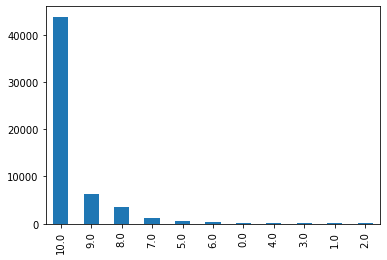

In [10]:
# Visualize SCORE distribution, total 11 scores, majority SCORE = 10
df_train['SCORE'].value_counts().plot(kind = 'bar')

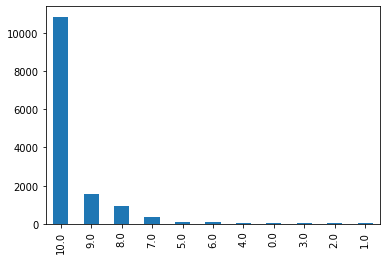

In [10]:
df_validate['SCORE'].value_counts().plot(kind = 'bar')

In [11]:
df_train.isnull().sum()

DOCUMENT_ID            0
SENTENCE_ID            0
SENTENCE              21
SENTENCE_START_POS     0
SENTENCE_END_POS       0
SCORE                  0
dtype: int64

In [12]:
#Remove the missing data 
df_train = df_train.dropna()

In [13]:
df_train.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [14]:
df_train.shape

(56623, 6)

In [15]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              4
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 1
dtype: int64

In [16]:
df_validate = df_validate.dropna()

In [17]:
df_validate.isnull().sum()

DOCUMENT_ID           0
SENTENCE_ID           0
SENTENCE              0
SENTENCE_START_POS    0
SENTENCE_END_POS      0
SCORE                 0
dtype: int64

In [18]:
df_validate.shape

(14014, 6)

## Preprocess Sentences

In [19]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [20]:
# Define preprocess function, remove stop words and punctuations etc.
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
stop = set(stopwords.words('english'))
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean_text(text):
    text = text.lower()
    wordList = text.split()
    wordList = ["".join(x for x in word if (x=="'")|(x not in punc)) for word in wordList]
    wordList = [word for word in wordList if word not in stop]
    wordList = [lemma.lemmatize(word) for word in wordList]
    return " ".join(wordList)
clean_text("I Thank you!")

'thank'

In [21]:
# Clean train dataset
df_train["SENTENCE"] = df_train["SENTENCE"].astype("str")
df_train["clean_text"] = df_train["SENTENCE"].apply(clean_text)

In [22]:
# Clean validate dataset
df_validate["SENTENCE"] = df_validate["SENTENCE"].astype("str")
df_validate["clean_text"] = df_validate["SENTENCE"].apply(clean_text)

In [23]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE,clean_text
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0,whole process went smooth thankful
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0,quick easy apply got approval quickly
2,584193040,1909902,service,0,7,10.0,service
3,584203035,1910310,Thanks!,198,205,10.0,thanks
4,584200037,1910006,Thank you!,58,68,10.0,thank


In [ ]:
#save cleaned data to Google drive
#df_train.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_train.csv')
#df_validate.to_csv(path_or_buf='/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [ ]:
#upload the cleaned data
#df_train = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_train.csv')
#df_validation = pd.read_csv('/content/drive/My Drive/Data_Sets/NLP_validate.csv')

In [25]:
df_train.head()

,DOCUMENT_ID,SENTENCE_ID,SENTENCE,SENTENCE_START_POS,SENTENCE_END_POS,SCORE,clean_text
0,583306034,1888104,The whole process went smooth and I am thankfu...,109,165,10.0,whole process went smooth thankful
1,583306034,1888102,It was quick and easy to apply and got the app...,0,60,10.0,quick easy apply got approval quickly
2,584193040,1909902,service,0,7,10.0,service
3,584203035,1910310,Thanks!,198,205,10.0,thanks
4,584200037,1910006,Thank you!,58,68,10.0,thank


## Random Forest Prediction
### Using Tf-Idf Vectorizer
### Training accuracy much improved than Neural Network LSTM/GRU; Validation accuracy is similar.

In [27]:
xtrain = df_train['clean_text']
ytrain = df_train['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif

In [31]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain_vectorized = vectorizer.fit_transform(xtrain)
xtest_vectorized=vectorizer.transform(xtest)

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain_vectorized,ytrain)

RandomForestClassifier(n_estimators=50)

### Training Classification_report, Accuracy, 

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain_vectorized)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.90      0.94       227
         1.0       1.00      0.87      0.93        83
         2.0       0.97      0.82      0.89        79
         3.0       0.97      0.88      0.93       127
         4.0       0.98      0.88      0.92       192
         5.0       0.97      0.82      0.89       516
         6.0       0.98      0.78      0.87       433
         7.0       0.93      0.69      0.79      1297
         8.0       0.92      0.61      0.73      3625
         9.0       0.96      0.54      0.69      6212
        10.0       0.90      1.00      0.95     43832

    accuracy                           0.91     56623
   macro avg       0.96      0.80      0.87     56623
weighted avg       0.91      0.91      0.90     56623

0.9092948095296964


In [43]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  205     0     0     1     0     0     0     3     7     0    11]
 [    0    72     1     2     0     0     0     0     1     1     6]
 [    0     0    65     0     0     1     0     1     4     1     7]
 [    1     0     1   112     0     0     1     0     6     0     6]
 [    0     0     0     0   168     2     0     3     4     0    15]
 [    1     0     0     0     0   424     2    11    27     1    50]
 [    2     0     0     0     0     1   339     7    17     5    62]
 [    0     0     0     0     1     3     2   899    49     6   337]
 [    1     0     0     0     1     4     2    17  2205    20  1375]
 [    1     0     0     0     1     2     0    10    30  3346  2822]
 [    0     0     0     0     1     2     1    15    47   114 43652]]


### Validation Classification Report, Accuracy

In [44]:
ypred=rf.predict(xtest_vectorized)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.12      0.03      0.05        35
         1.0       0.00      0.00      0.00        17
         2.0       0.25      0.05      0.08        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.05      0.01      0.02       111
         6.0       0.07      0.01      0.02        97
         7.0       0.25      0.06      0.09       332
         8.0       0.27      0.07      0.12       904
         9.0       0.17      0.02      0.04      1562
        10.0       0.79      0.98      0.88     10864

    accuracy                           0.77     14014
   macro avg       0.18      0.11      0.12     14014
weighted avg       0.66      0.77      0.69     14014

0.7676609105180534


In [45]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[    1     0     0     0     0     0     0     2     8     0    24]
 [    0     0     0     0     0     0     1     1     3     0    12]
 [    1     0     1     0     0     0     0     2     1     0    15]
 [    0     0     1     0     0     1     0     0     2     0    22]
 [    1     0     0     0     0     1     2     1     4     2    35]
 [    0     0     0     2     1     1     0     2    19     0    86]
 [    2     0     0     1     1     2     1     6    22     1    61]
 [    1     1     0     1     0     4     1    19    28     5   272]
 [    0     1     1     1     0     4     3    16    67    41   770]
 [    1     0     0     1     0     3     0    10    22    36  1489]
 [    1     1     1     0     1     3     6    18    69   132 10632]]


## Naive_Bayes Prediction
### Training accuracy very low, Naive_Bayes not work in this case

In [46]:
from sklearn.naive_bayes import GaussianNB

In [51]:
nb = GaussianNB()

In [53]:
xtrain_vectorized = xtrain_vectorized.toarray()

In [54]:
nb.fit(xtrain_vectorized, ytrain)


GaussianNB()

In [58]:
ytrain_pred=nb.predict(xtrain_vectorized)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.12      0.66      0.20       227
         1.0       0.03      0.92      0.06        83
         2.0       0.02      1.00      0.03        79
         3.0       0.03      0.76      0.05       127
         4.0       0.02      0.67      0.04       192
         5.0       0.05      0.44      0.09       516
         6.0       0.02      0.57      0.03       433
         7.0       0.05      0.31      0.09      1297
         8.0       0.14      0.18      0.16      3625
         9.0       0.18      0.12      0.14      6212
        10.0       1.00      0.06      0.11     43832

    accuracy                           0.09     56623
   macro avg       0.15      0.51      0.09     56623
weighted avg       0.81      0.09      0.11     56623

0.09353089733853734


In [59]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  149    15    29    16    18     0     0     0     0     0     0]
 [    0    76     7     0     0     0     0     0     0     0     0]
 [    0     0    79     0     0     0     0     0     0     0     0]
 [    0     9    21    97     0     0     0     0     0     0     0]
 [    0    18    35    11   128     0     0     0     0     0     0]
 [   27    23    95    42    40   225    64     0     0     0     0]
 [   14    34    71    30    38     0   246     0     0     0     0]
 [   40    70   168   132   105    89   295   398     0     0     0]
 [   80   150   393   262   353   249  1038   426   635    39     0]
 [   99   195   508   403   656   467  1961   851   349   723     0]
 [  836  1859  3242  2628  4493  3350 12310  5843  3435  3296  2540]]


## With NLP Augmentation

In [60]:
df_aug = df_train[['SENTENCE_ID', 'SCORE', 'clean_text']]
df_aug.head()

,SENTENCE_ID,SCORE,clean_text
0,1888104,10.0,whole process went smooth thankful
1,1888102,10.0,quick easy apply got approval quickly
2,1909902,10.0,service
3,1910310,10.0,thanks
4,1910006,10.0,thank


In [61]:
df_aug.reset_index(drop=True, inplace=True)

In [62]:
xtrain = df_aug['clean_text']

In [63]:
ytrain = df_aug['SCORE']

In [64]:
df_test = df_validate[['SENTENCE_ID', 'SCORE', 'clean_text']]

In [65]:
df_test.head()

,SENTENCE_ID,SCORE,clean_text
7,1910601,10.0,loan process super easy
10,1909801,9.0,process quick easy
13,2116637,10.0,bank within day day submitted request
14,2116635,10.0,know mean score found process qualify fund req...
25,359794,10.0,expensive dental work debt consolidation


In [66]:
df_test.reset_index(drop=True, inplace=True)

In [67]:
xtest = df_test['clean_text']
ytest = df_test['SCORE']

In [68]:
!pip install nlpaug


     |████████████████████████████████| 410 kB 25.5 MB/s 
     |████████████████████████████████| 11.3 MB 41.8 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


In [69]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 27.1 MB/s 
     |████████████████████████████████| 596 kB 57.4 MB/s 
     |████████████████████████████████| 61 kB 598 kB/s 
     |████████████████████████████████| 3.3 MB 57.9 MB/s 
     |████████████████████████████████| 895 kB 53.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [70]:
import nlpaug.augmenter.word as naw
# main parameters to adjust
ACTION = 'substitute' # or use 'insert'
TOP_K = 8 # randomly draw from top 8 suggested words
AUG_P = 0.40 # augment 40% of words within text
aug_bert = naw.ContextualWordEmbsAug(
model_path='bert-base-uncased',
action=ACTION,
top_k=TOP_K,
aug_p=AUG_P
)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [71]:
aug_sentences=[]
aug_sent_labels=[]
for i in xtrain.index:
  if ytrain[i]==0.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(0.0)
  elif ytrain[i]==1.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(1.0)
  elif ytrain[i]==2.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(2.0)
  elif ytrain[i]==3.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(3.0)
  
  elif ytrain[i]==4.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(4.0)
  elif ytrain[i]==5.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(5.0)
  elif ytrain[i]==6.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(6.0)
  elif ytrain[i]==7.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(7.0)
  elif ytrain[i]==8.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(8.0)
  elif ytrain[i]==9.0:
    temps=aug_bert.augment(xtrain[i],n=2)
    for sent in temps:
      aug_sentences.append(sent)
      aug_sent_labels.append(9.0)
  else:
    continue
 

In [72]:
xtrain=xtrain.append(pd.Series(aug_sentences),ignore_index=True)
ytrain=ytrain.append(pd.Series(aug_sent_labels),ignore_index=True)

print(xtrain.shape)
print(ytrain.shape)

(82159,)
(82159,)


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif

In [74]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain_vectorized = vectorizer.fit_transform(xtrain)
xtest_vectorized=vectorizer.transform(xtest)

In [75]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain_vectorized,ytrain)

RandomForestClassifier(n_estimators=50)

In [76]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain_vectorized)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.88      0.92       679
         1.0       0.95      0.84      0.89       247
         2.0       0.97      0.81      0.88       237
         3.0       0.96      0.86      0.91       379
         4.0       0.98      0.86      0.91       574
         5.0       0.96      0.80      0.87      1542
         6.0       0.96      0.78      0.86      1299
         7.0       0.93      0.69      0.79      3887
         8.0       0.90      0.63      0.74     10863
         9.0       0.78      0.80      0.79     18620
        10.0       0.88      0.98      0.93     43832

    accuracy                           0.87     82159
   macro avg       0.93      0.81      0.86     82159
weighted avg       0.87      0.87      0.86     82159

0.8663445270755487


In [77]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  598     0     1     0     0     2     2     4    16    49     7]
 [    0   208     1     2     0     0     0     1     5    25     5]
 [    0     0   192     0     0     3     0     2    13    20     7]
 [    2     0     0   325     0     2     0     1    12    30     7]
 [    0     0     0     1   492     2     1     9    14    40    15]
 [    1     0     0     0     0  1236     7    24    86   139    49]
 [    4     2     0     3     1     3  1007    18    82   119    60]
 [    6     2     0     2     3    11     9  2685   164   617   388]
 [    4     1     2     0     3    14    15    64  6870  2260  1630]
 [    1     5     2     2     4    12     6    47   313 14816  3412]
 [    2     0     0     2     0     6     5    33    99   936 42749]]


In [78]:
ypred=rf.predict(xtest_vectorized)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.29      0.10      0.15        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.06      0.01      0.02       111
         6.0       0.11      0.01      0.02        97
         7.0       0.18      0.05      0.08       332
         8.0       0.23      0.08      0.12       904
         9.0       0.14      0.06      0.08      1562
        10.0       0.80      0.95      0.87     10864

    accuracy                           0.75     14014
   macro avg       0.16      0.11      0.12     14014
weighted avg       0.66      0.75      0.69     14014

0.7481090338233195


In [79]:
cm = confusion_matrix(ytest,ypred)
print(cm)

[[    0     0     0     0     0     0     0     3    11     4    17]
 [    0     0     1     1     0     0     0     2     2     1    10]
 [    1     0     2     0     0     0     0     2     2     1    12]
 [    0     0     0     0     0     1     0     1     3     2    19]
 [    1     0     0     0     0     0     0     1     6     2    36]
 [    1     0     0     1     0     1     0     4    17    12    75]
 [    2     0     0     0     2     1     1     7    24     5    55]
 [    1     1     1     1     0     4     1    17    33    34   239]
 [    0     1     0     1     0     6     2    26    73    77   718]
 [    1     0     1     1     0     1     0     6    33    93  1426]
 [    1     3     2     1     2     2     5    28   110   413 10297]]


## Undersampling, reduce majority (SCORER=10.0)

### Results slightly worse

In [37]:
df_train['SCORE'].value_counts()

10.0    43832
9.0      6212
8.0      3625
7.0      1297
5.0       516
6.0       433
0.0       227
4.0       192
3.0       127
1.0        83
2.0        79
Name: SCORE, dtype: int64

In [49]:
df_balance = df_train.copy()
df_balance = df_balance[1:20000] ## delete labels from first 80000 (dont want to delete all)
df_balance.drop(df_balance[df_balance['SCORE'] == 10.0].index, inplace = True)

# Add the rest of untouched rows
df_balance = pd.concat([df_balance,df_train[20001:]], axis=0)

In [50]:
df_balance.shape

(41332, 7)

In [51]:
df_balance['SCORE'].value_counts()

10.0    28541
9.0      6212
8.0      3625
7.0      1297
5.0       516
6.0       433
0.0       227
4.0       192
3.0       127
1.0        83
2.0        79
Name: SCORE, dtype: int64

In [52]:
xtrain = df_balance['clean_text']
ytrain = df_balance['SCORE']
xtest = df_validate['clean_text']
ytest = df_validate['SCORE']

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2,f_classif, mutual_info_classif

In [54]:
vectorizer = TfidfVectorizer(min_df=3,analyzer='word',max_features=3000)
xtrain_vectorized = vectorizer.fit_transform(xtrain)
xtest_vectorized=vectorizer.transform(xtest)

In [55]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=50)

rf.fit(xtrain_vectorized,ytrain)

RandomForestClassifier(n_estimators=50)

### Evaluation the Train dataset

In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

ytrain_pred=rf.predict(xtrain_vectorized)

print(classification_report(ytrain,ytrain_pred))
print(accuracy_score(ytrain, ytrain_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.89      0.93       227
         1.0       0.99      0.89      0.94        83
         2.0       0.98      0.82      0.90        79
         3.0       0.97      0.88      0.92       127
         4.0       0.98      0.88      0.93       192
         5.0       0.93      0.83      0.88       516
         6.0       0.96      0.80      0.87       433
         7.0       0.87      0.72      0.79      1297
         8.0       0.90      0.63      0.74      3625
         9.0       0.95      0.56      0.71      6212
        10.0       0.87      0.99      0.93     28541

    accuracy                           0.88     41332
   macro avg       0.94      0.81      0.87     41332
weighted avg       0.89      0.88      0.87     41332

0.8809880963902061


In [57]:
cm1 = (confusion_matrix(ytrain,ytrain_pred))
print(cm1)

[[  203     0     0     0     0     2     1     5     6     0    10]
 [    0    74     0     1     0     1     0     0     1     2     4]
 [    0     1    65     1     0     1     0     2     4     0     5]
 [    2     0     0   112     0     1     0     4     3     0     5]
 [    0     0     0     0   169     2     0     5     3     1    12]
 [    1     0     0     0     1   426     2    24    21     3    38]
 [    1     0     0     1     1     1   345    16    23     4    41]
 [    1     0     0     0     1     7     2   931    48     6   301]
 [    1     0     0     0     0     8     3    44  2283    31  1255]
 [    1     0     1     0     0     4     2    17    48  3505  2634]
 [    1     0     0     1     0     3     4    21    83   128 28300]]


In [58]:
ypred=rf.predict(xtest_vectorized)
print(classification_report(ytest,ypred))
print(accuracy_score(ytest, ypred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.00      0.00      0.00        17
         2.0       0.00      0.00      0.00        20
         3.0       0.00      0.00      0.00        26
         4.0       0.00      0.00      0.00        46
         5.0       0.06      0.02      0.03       111
         6.0       0.07      0.01      0.02        97
         7.0       0.19      0.08      0.11       332
         8.0       0.26      0.09      0.14       904
         9.0       0.16      0.04      0.06      1562
        10.0       0.80      0.96      0.87     10864

    accuracy                           0.76     14014
   macro avg       0.14      0.11      0.11     14014
weighted avg       0.66      0.76      0.69     14014

0.7557442557442557


In [59]:
cm1 = (confusion_matrix(ytest,ypred))
print(cm1)

[[    0     0     1     1     0     0     1     6     3     1    22]
 [    0     0     1     0     0     0     0     2     3     0    11]
 [    1     0     0     0     0     0     0     2     2     0    15]
 [    0     0     0     0     1     1     0     0     3     0    21]
 [    1     0     0     0     0     1     0     0     6     0    38]
 [    1     0     0     2     1     2     0     7    14     2    82]
 [    2     0     0     1     1     3     1    19    14     5    51]
 [    1     1     1     1     0     9     5    26    27    11   250]
 [    0     1     3     1     1     7     3    27    85    53   723]
 [    1     0     1     1     2     4     0    11    31    61  1450]
 [    1     0     2     2     3     4     4    34   143   255 10416]]


# Summary and Improvement:

## 1. Using Random Forest with TF-IDF vectorizring, the train acc reached 0.91 and test acc reached 0.77.
## 2. Nlpaug can largely increase the minority classes sample size, but both train and validation acc slightly lower.
## 3. Reduce the majority sample size didn't help to improve the model performance in this case.
## 4. Naive Bayes is widely used for fraud detection (imbalance) but didn't work in this case.
## Improvement:
## 1. Oversampling: For the words, Nlpaug tried 'substitute', can try 'insert'. After vectorizing the sentence, try SMOTE.        
## 2. Undersampling: Try NearMiss technique, which remove majority samples near to minority samples.
## 3. Understand the domain knowledge of dataset, which may help the data preprocessing, such as combine some minority classes to be 1 class, reduce total number of classes.
## 4. TF_IDF vector is sparse, while pre-trained embeddings such as GloVe is dense. TRy to use GloVe embeddings conbime SKlearn to do prediction. 

